In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import copy

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#Amsterdam
amsterdam_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekdays.csv')
amsterdam_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekends.csv')

#Athens
athens_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekdays.csv')
athens_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekends.csv')

#Barcelona
barcelona_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv')
barcelona_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekends.csv')

#Berlin
berlin_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekdays.csv')
berlin_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekends.csv')

#Budapest
budapest_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekdays.csv')
budapest_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekends.csv')

#Lisbon
lisbon_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekdays.csv')
lisbon_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekends.csv')

#London
london_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekdays.csv')
london_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekends.csv')

#Paris
paris_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekdays.csv')
paris_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekends.csv')

#Rome
rome_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekdays.csv')
rome_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekends.csv')

#Vienna
vienna_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekdays.csv')
vienna_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekends.csv')

In [3]:
# path = "/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv"
# df = pd.read_csv(path, index_col=0)
# df.head()

In [4]:
datasets = [
    (amsterdam_weekdays, "Amsterdam", True),
    (amsterdam_weekend, "Amsterdam", False),
    (athens_weekdays, "Athens", True),
    (athens_weekend, "Athens", False),
    (barcelona_weekdays, "Barcelona", True),
    (barcelona_weekend, "Barcelona", False),
    (berlin_weekdays, "Berlin", True),
    (berlin_weekend, "Berlin", False),
    (budapest_weekdays, "Budapest", True),
    (budapest_weekend, "Budapest", False),
    (lisbon_weekdays, "Lisbon", True),
    (lisbon_weekend, "Lisbon", False),
    (london_weekdays, "London", True),
    (london_weekend, "London", False),
    (paris_weekdays, "Paris", True),
    (paris_weekend, "Paris", False),
    (rome_weekdays, "Rome", True),
    (rome_weekend, "Rome", False),
    (vienna_weekdays, "Vienna", True),
    (vienna_weekend, "Vienna", False)
]

df = pd.DataFrame()

for data, city, is_weekday in datasets:
    data['city'] = city
    data['weekday'] = is_weekday
    df = pd.concat([df, data], ignore_index=True)

df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

print(df.head())
print(df.shape)

      realSum     room_type  room_shared  room_private  person_capacity  \
0  194.033698  Private room        False          True              2.0   
1  344.245776  Private room        False          True              4.0   
2  264.101422  Private room        False          True              2.0   
3  433.529398  Private room        False          True              4.0   
4  485.552926  Private room        False          True              2.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0              False      1    0                10.0   
1              False      0    0                 8.0   
2              False      0    1                 9.0   
3              False      0    1                 9.0   
4               True      0    0                10.0   

   guest_satisfaction_overall  ...      dist  metro_dist  attr_index  \
0                        93.0  ...  5.022964    2.539380   78.690379   
1                        85.0  ...  0.488389    0.239404  631.176378

# Feature Selection/Extraction:

In [5]:
df_copy = df
# Encode categorical features
label_encoders = {}
for column in ['room_type', 'city']:
    le = LabelEncoder()
    df_copy[column] = le.fit_transform(df_copy[column])
    label_encoders[column] = le

# Convert boolean columns to int (True/False to 1/0)
bool_columns = ['room_shared', 'room_private', 'host_is_superhost', 'weekday']
for column in bool_columns:
    df_copy[column] = df_copy[column].astype(int)

# Show the updated dataframe and check types again
df_copy.head(), df_copy.dtypes

(      realSum  room_type  room_shared  room_private  person_capacity  \
 0  194.033698          1            0             1              2.0   
 1  344.245776          1            0             1              4.0   
 2  264.101422          1            0             1              2.0   
 3  433.529398          1            0             1              4.0   
 4  485.552926          1            0             1              2.0   
 
    host_is_superhost  multi  biz  cleanliness_rating  \
 0                  0      1    0                10.0   
 1                  0      0    0                 8.0   
 2                  0      0    1                 9.0   
 3                  0      0    1                 9.0   
 4                  1      0    0                10.0   
 
    guest_satisfaction_overall  ...      dist  metro_dist  attr_index  \
 0                        93.0  ...  5.022964    2.539380   78.690379   
 1                        85.0  ...  0.488389    0.239404  631.176378 

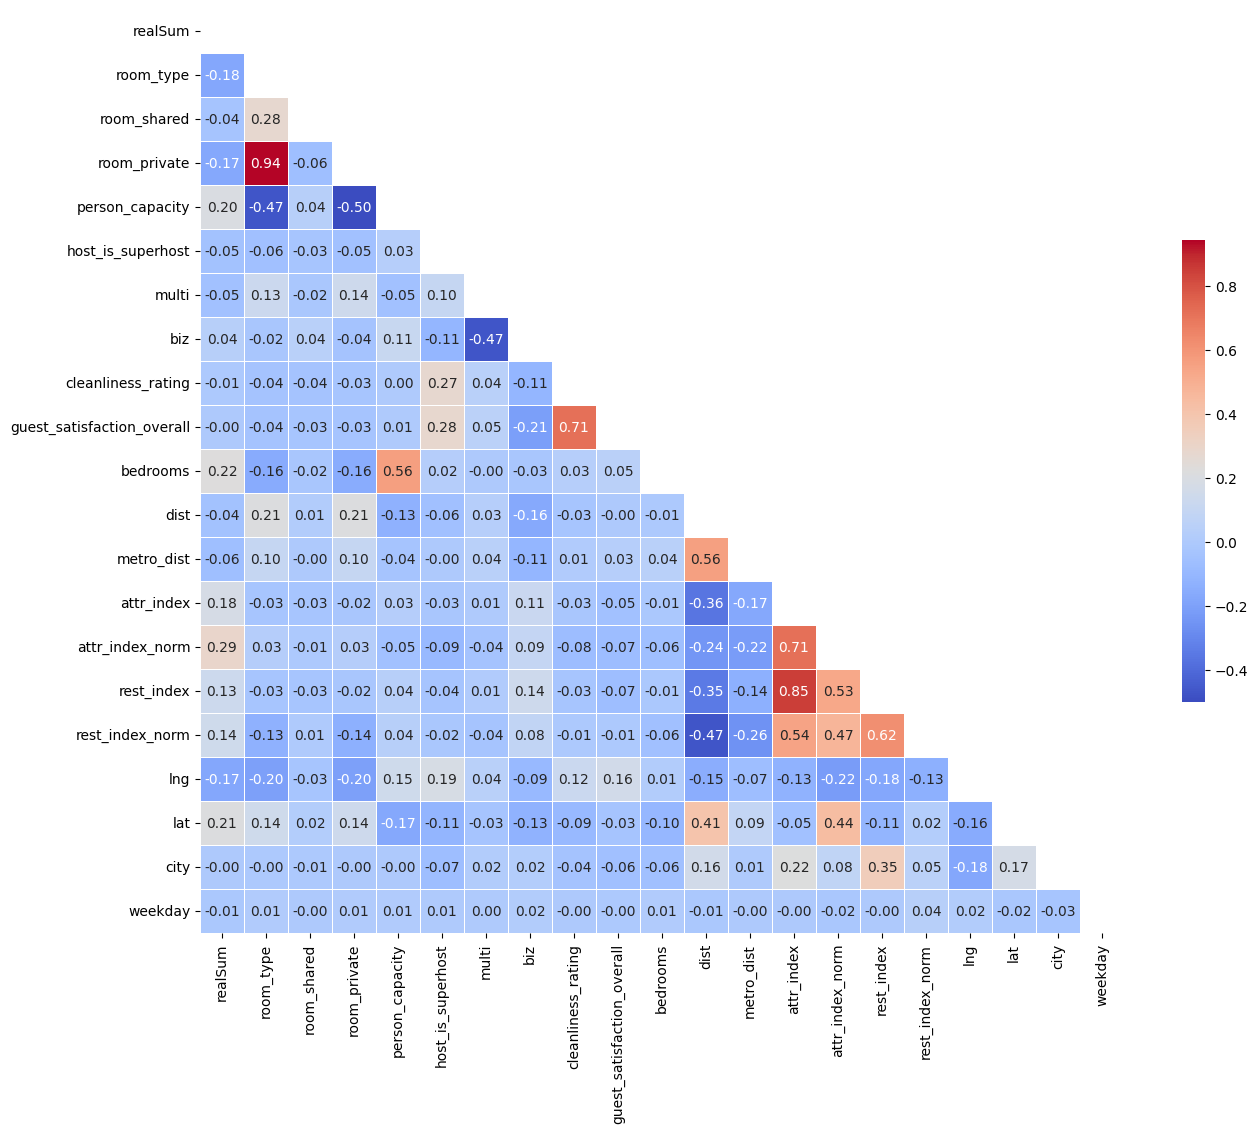

In [6]:
# Compute the correlation matrix
corr_matrix = df_copy.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show plot
plt.show()

In [7]:
# Calculate the correlation matrix
correlation_matrix = df_copy.corr()

# Filter out columns where the correlation with 'realSum' is between -0.1 and 0.1
low_correlation_columns = correlation_matrix[(correlation_matrix['realSum'] > -0.1) & (correlation_matrix['realSum'] < 0.1)].index

# Print the columns with low correlation
print(low_correlation_columns)

# Remove these columns from the dataset
df_reduced = df.drop(columns=low_correlation_columns)
print(df_reduced.head())

Index(['room_shared', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'dist',
       'metro_dist', 'city', 'weekday'],
      dtype='object')
      realSum  room_type  room_private  person_capacity  bedrooms  attr_index  \
0  194.033698          1             1              2.0         1   78.690379   
1  344.245776          1             1              4.0         1  631.176378   
2  264.101422          1             1              2.0         1   75.275877   
3  433.529398          1             1              4.0         2  493.272534   
4  485.552926          1             1              2.0         1  552.830324   

   attr_index_norm  rest_index  rest_index_norm      lng       lat  
0         4.166708   98.253896         6.846473  4.90569  52.41772  
1        33.421209  837.280757        58.342928  4.90005  52.37432  
2         3.985908   95.386955         6.646700  4.97512  52.36103  
3        26.119108  875.033098        60.973565 

# Data Visualization

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


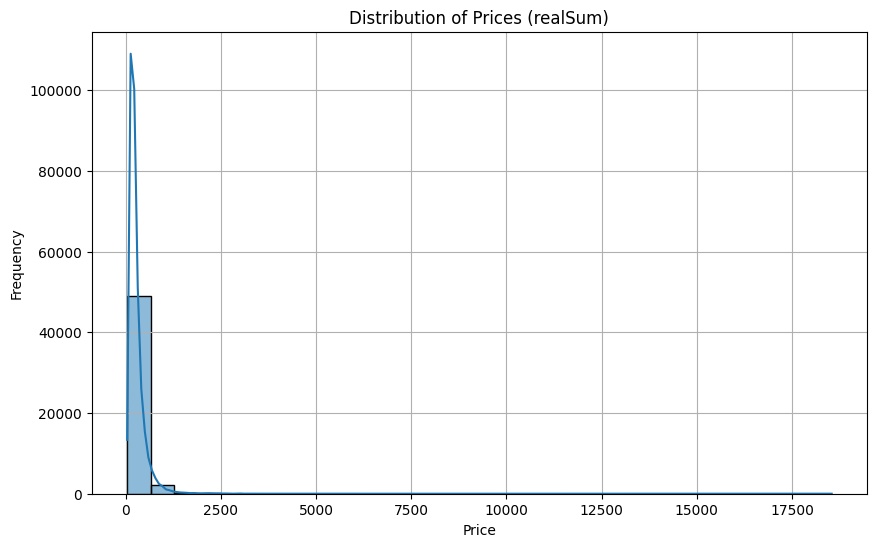

<function matplotlib.pyplot.show(close=None, block=None)>

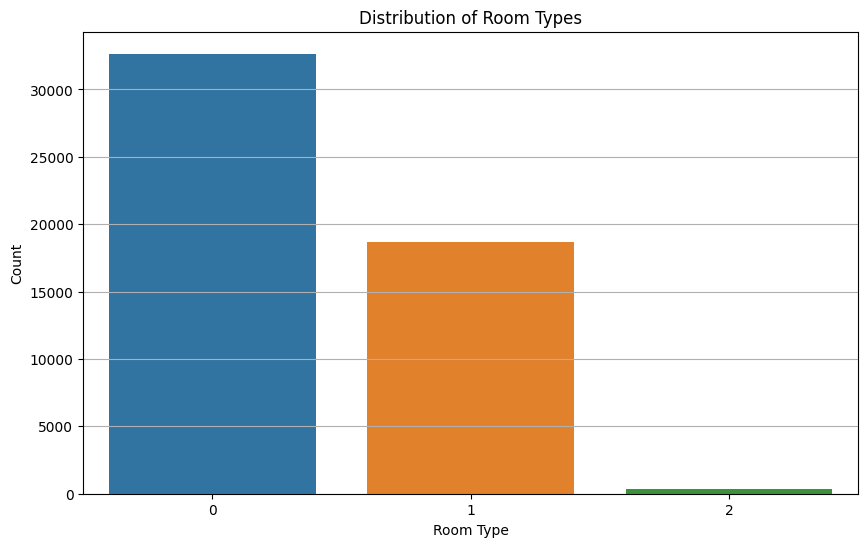

In [8]:
# 1. Summary Statistics for 'realSum'
plt.figure(figsize=(10, 6))
sns.histplot(df_reduced['realSum'], bins=30, kde=True)
plt.title('Distribution of Prices (realSum)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Distribution of Room Types
plt.figure(figsize=(10, 6))
sns.countplot(x='room_type', data=df_reduced)
plt.title('Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show

# Data Preposessing

## Add data shuffle

In [9]:
np.random.seed(144)
df_reduced = df_reduced.sample(frac=1).reset_index(drop=True)

## DEALING WITH MISSING VALUES

In [10]:
df_reduced.describe()

,realSum,room_type,room_private,person_capacity,bedrooms,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,0.375674,0.361518,3.161661,1.15876,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128
std,327.948386,0.498703,0.480445,1.298545,0.62741,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263
min,34.779339,0.000000,0.000000,2.000000,0.00000,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000
25%,148.752174,0.000000,0.000000,2.000000,1.00000,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510
50%,211.343089,0.000000,0.000000,3.000000,1.00000,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690
75%,319.694287,1.000000,1.000000,4.000000,1.00000,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885
max,18545.450285,2.000000,1.000000,6.000000,10.00000,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410


In [11]:
df_reduced.shape

(51707, 11)

In [12]:
df_complete = df_reduced.dropna()
df_complete.shape

(51707, 11)

## FINDING OUTLIERS

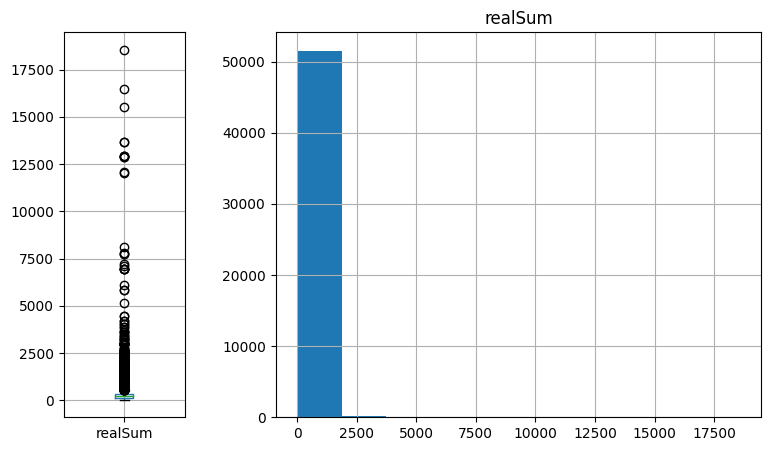

In [13]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df_complete.boxplot(column='realSum',ax=axes[0]);
df_complete.hist(column='realSum', ax=axes[1]);

In [14]:
Q1 = df_complete['realSum'].quantile(0.25)
Q3 = df_complete['realSum'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

(148.75217370869953, 319.69428651318856, 170.94211280448903)

In [15]:
small_outliers = df_complete['realSum'] < (Q1 - 1.5 * IQR)
big_outliers = df_complete['realSum'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(0, 3662)

In [16]:
df_complete['realSum'][small_outliers | big_outliers].head()

60     698.806972
66     956.983937
83     593.852160
95     636.702364
99    2311.738714
Name: realSum, dtype: float64

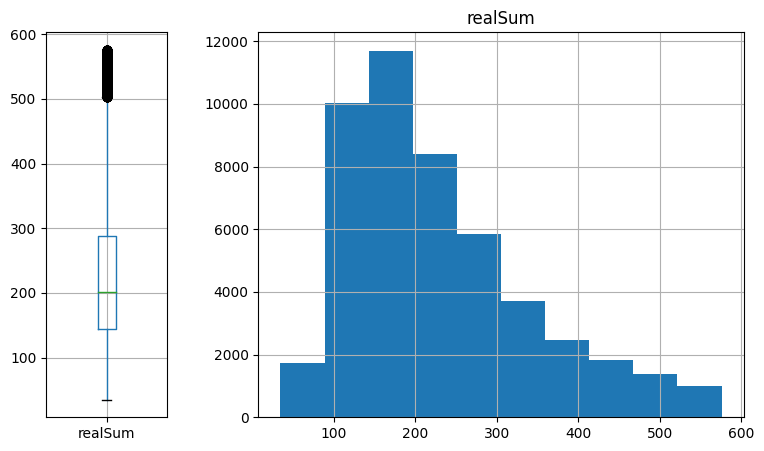

In [17]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df_complete[~(small_outliers | big_outliers)].boxplot(column='realSum',ax=axes[0]);
df_complete[~(small_outliers | big_outliers)].hist(column='realSum', ax=axes[1]);

In [18]:
df_clean = df_complete[~(small_outliers | big_outliers)]
df_clean.shape

(48045, 11)

In [19]:
df_clean.dtypes

realSum            float64
room_type            int64
room_private         int64
person_capacity    float64
bedrooms             int64
attr_index         float64
attr_index_norm    float64
rest_index         float64
rest_index_norm    float64
lng                float64
lat                float64
dtype: object

In [20]:
# df_clean.to_csv('out.csv', index=False) 

In [21]:
# # Identifying categorical and numerical columns
# categorical_cols = [col for col in df_clean.columns if df_clean[col].dtype in ['object', 'bool']]
# numerical_cols = [col for col in df_clean.columns if df_clean[col].dtype in ['int64', 'float64'] and col != 'realSum']

# # Adjust transformers if necessary
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')
# numerical_transformer = StandardScaler()

# # Update preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols)
#         ('cat', categorical_transformer, categorical_cols)
#     ])

# # Fit and transform the data
# df_transformed = preprocessor.fit_transform(df_clean.drop('realSum', axis=1))

# # Check transformed feature names and dimensions
# transformed_features = preprocessor.transformers_[0][1].get_feature_names_out(numerical_cols).tolist() + \
#                        preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols).tolist()

# print(transformed_features)
# print(df_transformed.shape)

In [22]:
# There is only numeric data left, so we only need to StandardScaler Numeric data
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(df_clean[numeric_cols])
df_transformed = pd.DataFrame(scaled_numeric_data, columns=numeric_cols)

df_transformed = df_transformed.to_numpy()
df_transformed

array([[ 0.40961544, -0.78685191, -0.78592415, ..., -0.94528463,
         0.86040239,  0.54547294],
       [-0.59425435, -0.78685191, -0.78592415, ..., -0.85370918,
         1.59540114, -1.40704013],
       [ 0.54312718, -0.78685191, -0.78592415, ..., -1.0996111 ,
         0.86310201,  0.54547294],
       ...,
       [-1.24827826,  1.19523271,  1.27238742, ..., -0.56457102,
        -1.69042723, -1.26651804],
       [ 2.1545938 , -0.78685191, -0.78592415, ..., -0.4296594 ,
         0.4740786 , -0.66585899],
       [-0.02015759,  1.19523271,  1.27238742, ...,  1.32965538,
        -0.53977873,  0.66778635]])

# Prepare Training Data

In [23]:
# y = df_clean['realSum'].values

# # Create Train Data and Test Data
# X_train, X_test, y_train, y_test = train_test_split(df_transformed, y, test_size=0.2, random_state=42)
# X_train = torch.tensor(X_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

# # Create DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [24]:
y = df_clean['realSum'].values

# Split Test Data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_transformed, y, test_size=0.2, random_state=42)

# Split Validation Data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define SVM Model

In [25]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [26]:
class SVR(nn.Module):
    def __init__(self, n_features):
        super(SVR, self).__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

In [27]:
def epsilon_insensitive_loss(outputs, targets, epsilon=0.1):
    errors = torch.abs(targets - outputs.squeeze())

    loss = torch.mean(torch.max(errors - epsilon, torch.zeros_like(errors)))
    return loss

In [28]:
model = SVR(X_train.shape[1]).to(device)
print(model)

SVR(
  (linear): Linear(in_features=11, out_features=1, bias=True)
)


In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

In [30]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0001):  
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.reset()

    def reset(self):
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:  
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")
        else:
            self.best_score = score
            self.epochs_no_improve = 0

# Model Training

In [31]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.001):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = SVR(n_features=X_train.shape[1]).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=10, verbose=True)

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = epsilon_insensitive_loss(output, target, epsilon)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
            val_loss /= len(val_loader)

            print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')

            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'SVR_best_model.pth')  # Save model to disk

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [32]:
cross_validate_model(df_transformed, y, n_splits=5, epochs=20, batch_size=32, lr=0.01, epsilon=0.001)

Starting fold 1
Fold 1, Epoch 1, Validation MAE Loss: 219.2177291173658
Fold 1, Epoch 2, Validation MAE Loss: 209.74690037644257
Fold 1, Epoch 3, Validation MAE Loss: 200.3666372338766
Fold 1, Epoch 4, Validation MAE Loss: 191.07696723146557
Fold 1, Epoch 5, Validation MAE Loss: 181.88571768479724
Fold 1, Epoch 6, Validation MAE Loss: 172.81990906014977
Fold 1, Epoch 7, Validation MAE Loss: 163.9171877659208
Fold 1, Epoch 8, Validation MAE Loss: 155.24275726698247
Fold 1, Epoch 9, Validation MAE Loss: 146.86328175651582
Fold 1, Epoch 10, Validation MAE Loss: 138.79217424827988
Fold 1, Epoch 11, Validation MAE Loss: 131.05407638866376
Fold 1, Epoch 12, Validation MAE Loss: 123.6254236055113
Fold 1, Epoch 13, Validation MAE Loss: 116.48342673907142
Fold 1, Epoch 14, Validation MAE Loss: 109.63757482504944
Fold 1, Epoch 15, Validation MAE Loss: 103.11007329537166
Fold 1, Epoch 16, Validation MAE Loss: 96.89006650299451
Fold 1, Epoch 17, Validation MAE Loss: 90.98630655059182
Fold 1, Epoch

75.05499131452

In [33]:
# param_grid = {
#     'lr': [0.01, 0.001, 0.0001],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'batch_size': [32, 64, 128]
# }

# best_model_params = None
# lowest_val_loss = np.inf
# grid = list(ParameterGrid(param_grid))

# for params in grid:
#     print("Testing parameters:", params)
#     current_val_loss = cross_validate_model(
#         X=df_transformed,
#         y=y,
#         n_splits=5,
#         epochs=500,
#         batch_size=params['batch_size'],
#         epsilon=0.1,
#         lr=params['lr'],
#         weight_decay=params['weight_decay']
#     )
    
#     if current_val_loss < lowest_val_loss:
#         lowest_val_loss = current_val_loss
#         best_model_params = copy.deepcopy(params)

# print(f"Best Validation Loss: {lowest_val_loss}")
# print("Best parameters:", best_model_params)

# Test Results

In [34]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SVR(n_features=input_features).to(device)
    model.load_state_dict(torch.load('SVR_best_model.pth', map_location=device))
    return model, device

best_model, device = load_best_model(df_transformed.shape[1])

In [35]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += epsilon_insensitive_loss(output, target, 0.1).item()  # 假设 epsilon=0.1
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')

evaluate_model(best_model, test_loader, device)

Test Loss: 73.96431590705518


In [36]:
def calculate_metrics(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}')

calculate_metrics(best_model, test_loader, device)

MSE: 10924.78515625, RMSE: 104.52169799804688, MAE: 74.0937271118164, R²: 0.13958567627944385


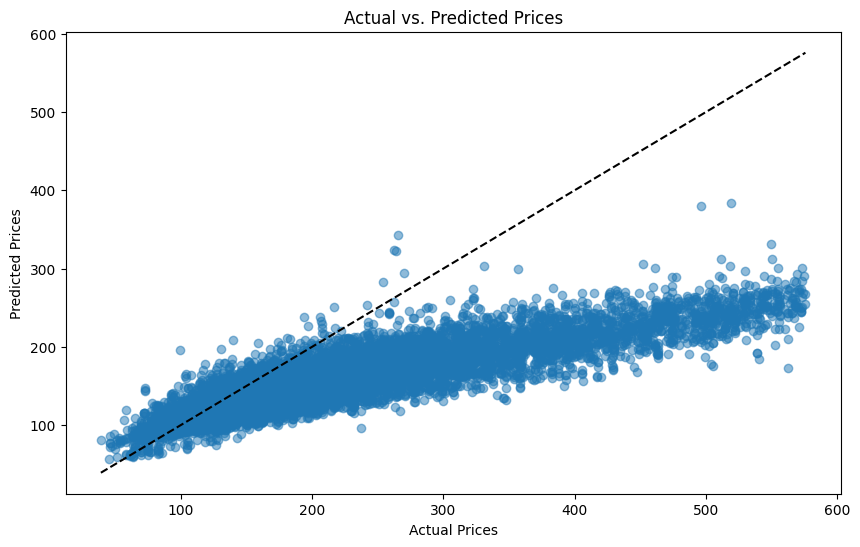

In [37]:
def plot_predictions(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs. Predicted Prices')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')
    plt.show()

plot_predictions(best_model, test_loader, device)

# *MLP* Model

In [38]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.output(x)
        return x

In [39]:
model = MLP(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.01):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = MLP(input_dim=X_train.shape[1]).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=10, verbose=True)

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = epsilon_insensitive_loss(output, target, epsilon)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
            val_loss /= len(val_loader)

            print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')
            
            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'MLP_best_model.pth')  # Save model to disk

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [41]:
cross_validate_model(df_transformed, y, n_splits=5, epochs=20, batch_size=32, lr=0.01, epsilon=0.0001)

Starting fold 1
Fold 1, Epoch 1, Validation MAE Loss: 58.96585842781542
Fold 1, Epoch 2, Validation MAE Loss: 20.053766610711442
Fold 1, Epoch 3, Validation MAE Loss: 12.842057358674488
Fold 1, Epoch 4, Validation MAE Loss: 14.582387295006717
Fold 1, Epoch 5, Validation MAE Loss: 22.70984051732107
Fold 1, Epoch 6, Validation MAE Loss: 13.304683162958295
Fold 1, Epoch 7, Validation MAE Loss: 8.387830985532261
Fold 1, Epoch 8, Validation MAE Loss: 6.223923968081652
Fold 1, Epoch 9, Validation MAE Loss: 11.613461108623204
Fold 1, Epoch 10, Validation MAE Loss: 7.075510782819566
Fold 1, Epoch 11, Validation MAE Loss: 20.02833627170547
Fold 1, Epoch 12, Validation MAE Loss: 7.258237541958504
Fold 1, Epoch 13, Validation MAE Loss: 14.500257903609533
Fold 1, Epoch 14, Validation MAE Loss: 6.987410400912969
Fold 1, Epoch 15, Validation MAE Loss: 10.549994049230552
Fold 1, Epoch 16, Validation MAE Loss: 9.225852188727668
Fold 1, Epoch 17, Validation MAE Loss: 10.1522289964668
Fold 1, Epoch 18, 

13.423705314303827

In [42]:
# param_grid = {
#     'lr': [0.01, 0.001, 0.0001],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'batch_size': [32, 64, 128]
# }

# best_model_params = None
# lowest_val_loss = np.inf
# grid = list(ParameterGrid(param_grid))

# for params in grid:
#     print("Testing parameters:", params)
#     current_val_loss = cross_validate_model(
#         X=df_transformed,
#         y=y,
#         n_splits=5,
#         epochs=500,
#         batch_size=params['batch_size'],
#         epsilon=0.1,
#         lr=params['lr'],
#         weight_decay=params['weight_decay']
#     )
    
#     if current_val_loss < lowest_val_loss:
#         lowest_val_loss = current_val_loss
#         best_model_params = copy.deepcopy(params)

# print(f"Best Validation Loss: {lowest_val_loss}")
# print("Best parameters:", best_model_params)

In [43]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP(input_dim=X_train.shape[1]).to(device)
    model.load_state_dict(torch.load('MLP_best_model.pth', map_location=device))
    return model, device

In [44]:
best_model, device = load_best_model(df_transformed.shape[1])

In [45]:
evaluate_model(best_model, test_loader, device)

Test Loss: 4.6388820765034255


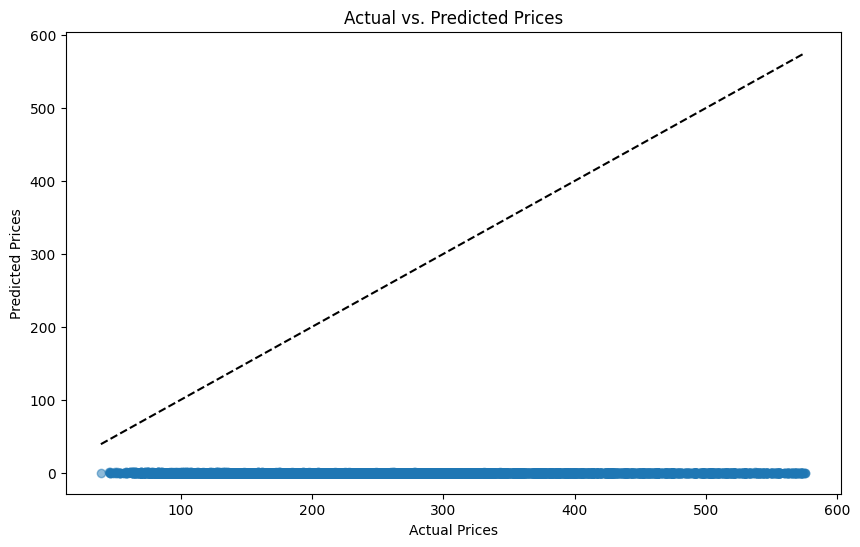

In [46]:
plot_predictions(model, test_loader, device)